### DDIM反转：利用反时间步退回到最开始的图像状态

In [1]:
# 导入依赖
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline,DDIMScheduler
import os

In [3]:
# 定义一个打开图片的函数，并将返回的字节通过PIL显示出来
def open_image(path):
    response = open(path, 'rb')
    img = Image.open(BytesIO(response.read())).convert('RGB')
    return img
# 定义计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [5]:
# 配置DDIM调度器
pipe.scheduler = DDIMScheduler.from_config(
    pipe.scheduler.config
)

  0%|          | 0/50 [00:00<?, ?it/s]

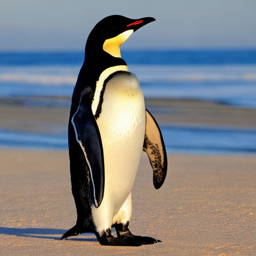

In [6]:
# 从中采样一次
prompt = "Beautiful DSLR Photograph of a penguin on the beach,golden hour"
negative_prompt = "blurry,ugly,stock photo"
im = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
).images[0]
im.resize((256,256))

### DDIM采样
在给定时刻$t$，带有噪声的图像$x_t$是用过对原始图像$x_0$加上高斯噪声$\epsilon$得到的，定义式如下：
$$
    x_t = \sqrt{\alpha_tx_0} + \sqrt{1-\alpha_t\epsilon}
$$

其中：
- $\epsilon$是方差归一化后的高斯噪声
- $\alpha_t$在DDPM是一个参考系数，在DDPM论文中记为$\bar{\alpha}$
- $\bar{\alpha}$将沿着时间步上的正方向恒下降

Text(0, 0.5, '$\\bar{\\alpha}$')

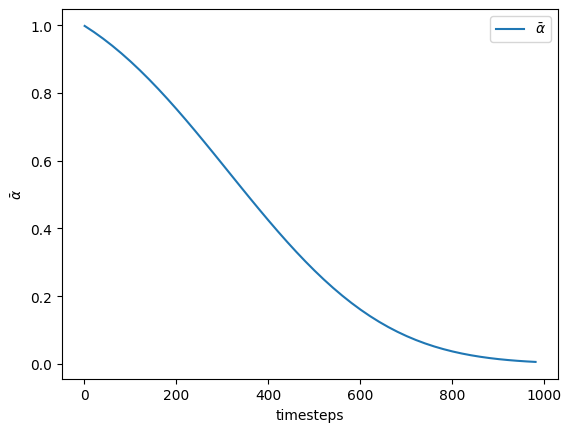

In [7]:
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps,alphas,label=r"$\bar{\alpha}$")
plt.xlabel("timesteps")
plt.legend()
plt.ylabel(r"$\bar{\alpha}$")

In [8]:

# Sample function (regular DDIM)
@torch.no_grad()
def sample(prompt, start_step=0, start_latents=None,
           guidance_scale=3.5, num_inference_steps=30,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):
    
        t = pipe.scheduler.timesteps[i]

        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)


        # Normally we'd rely on the scheduler to handle the update step:
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # Instead, let's do it ourselves:
        prev_t = max(1, t.item() - (1000//num_inference_steps)) # t-1
        alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        predicted_x0 = (latents - (1-alpha_t).sqrt()*noise_pred) / alpha_t.sqrt()
        direction_pointing_to_xt = (1-alpha_t_prev).sqrt()*noise_pred
        latents = alpha_t_prev.sqrt()*predicted_x0 + direction_pointing_to_xt

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

  0%|          | 0/50 [00:00<?, ?it/s]

/root/anaconda3/envs/hugging/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:429: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


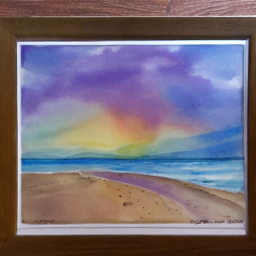

In [9]:
sample(
    'Watercolor painting of a beach sunset',
    negative_prompt=negative_prompt,
    num_inference_steps=50)[0].resize((256,256))

### DDIM反转

In [10]:
input_image = open_image(
    "./pexels-photo-8306128.jpeg"
).resize((512,512))

In [11]:
input_image_prompt = "Photograph of a puppy on the grass"
# 使用VAE创建一个初始的隐变量
with torch.no_grad():
    latent = pipe.vae.encode(
        tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1
    )
l = 0.18125 * latent.latent_dist.sample()

In [19]:
# 定义反转函数
@torch.no_grad()
def invert(
    start_latents,
    prompt,
    guidance_scale=3.5,
    num_inference_steps=80,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt='',
    device=device
):
    # 对提示文本进行编码
    text_embeddings = pipe._encode_prompt(
        prompt,device,num_images_per_prompt,do_classifier_free_guidance,negative_prompt
    )
    # 已经指定好初始隐空间
    latents = start_latents.clone()
    # 用一个列表存储反转的隐空间
    intermediate_latents = []
    # 配置推理的步数
    pipe.scheduler.set_timesteps(num_inference_steps,device=device)
    # 反转的时间步
    timesteps = reversed(pipe.scheduler.timesteps)
    # 循环采样
    for i in tqdm(range(1,num_inference_steps),total=num_inference_steps-1):
        # 跳过最后一次迭代
        if i >= num_inference_steps - 1:
            continue
        # 获取当前时间步
        t = timesteps[i]
        # 检查是否执行CFG引导，如果是，就扩展隐空间
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input,t)
        # 预测残留的噪声
        noise_pred = pipe.unet(latent_model_input,t,encoder_hidden_states=text_embeddings).sample
        # 执行引导
        if do_classifier_free_guidance:
            # 分离无条件的噪声和文本噪声
            noise_pred_uncond,noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        # 计算t
        current_t = max(0,t.item() - (1000//num_inference_steps))
        # 计算t+1
        next_t = t
        # 计算alpha_t
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        # 计算alpha_t+1
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]
        # 反转步更新
        latents = (latents - (1-alpha_t).sqrt()*noise_pred) * (alpha_t_next.sqrt() / alpha_t.sqrt()) + (1-alpha_t_next).sqrt()*noise_pred
        # 保存中间的隐空间
        intermediate_latents.append(latents)
    # 合并中间的隐空间
    return torch.cat(intermediate_latents)

In [20]:
inverted_latents = invert(
    l,
    input_image_prompt,
    num_inference_steps=50,
)
inverted_latents.shape

  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([48, 4, 64, 64])

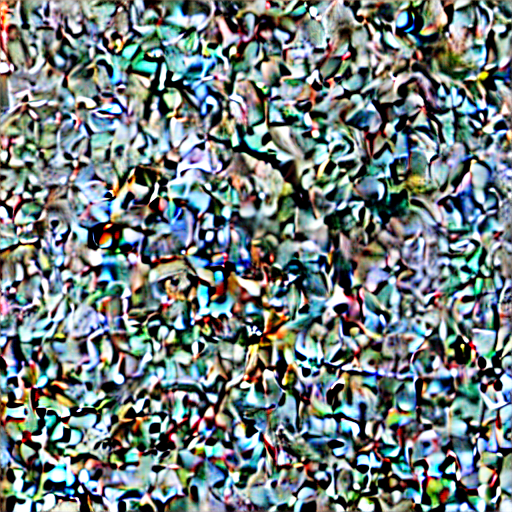

In [21]:
# 解码反转的最后一个隐空间
with torch.no_grad():
    im = pipe.decode_latents(inverted_latents[-1].unsqueeze(0))
pipe.numpy_to_pil(im)[0]

  0%|          | 0/50 [00:00<?, ?it/s]

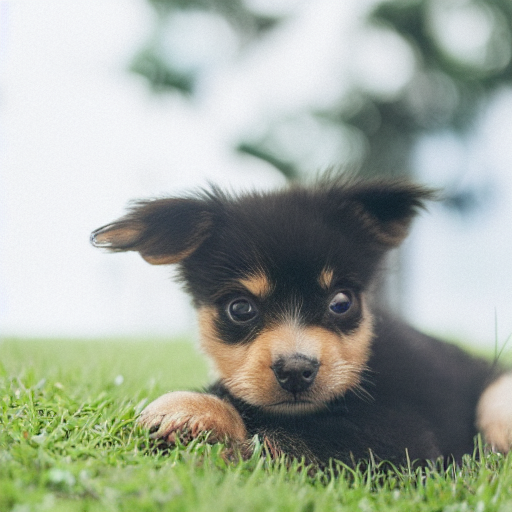

In [22]:
# 通过常规调用方法call，将反转隐空间传递给管线
pipe(
    input_image_prompt,
    latents=inverted_latents[-1][None],
    num_inference_steps=50,
    guidance_scale=3.5
).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

/root/anaconda3/envs/hugging/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:429: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


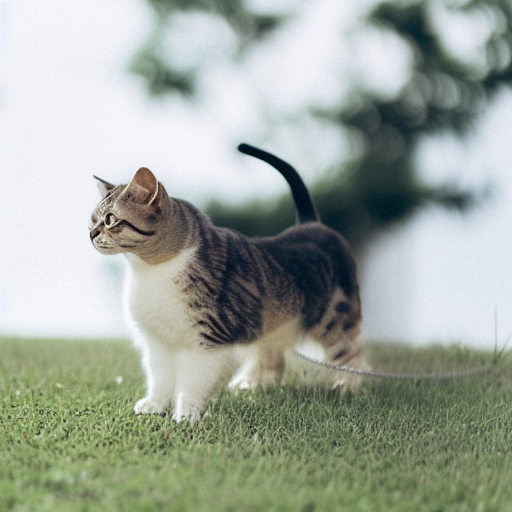

In [23]:
# 使用新的文本，并结合这个反转的隐空间生成新图像
start_step = 10 # 从第10步开始
new_prompt = input_image_prompt.replace("puppy","cat")
sample(
    new_prompt,
    start_latents=inverted_latents[-(start_step+1)][None],
    start_step=start_step,
    num_inference_steps=50,
)[0]

  0%|          | 0/40 [00:00<?, ?it/s]

/root/anaconda3/envs/hugging/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:429: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


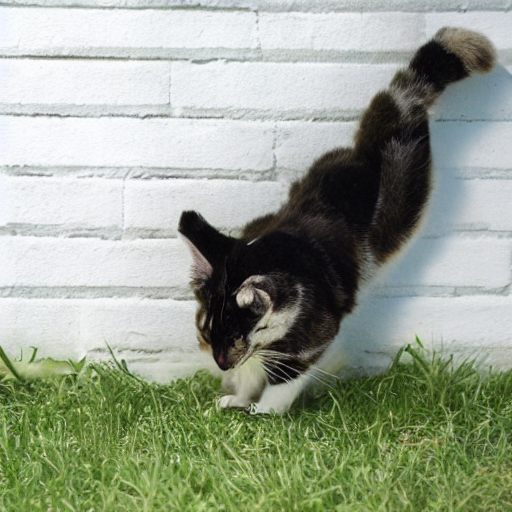

In [24]:
# 可你不能把这个过程想当然的理解为使Img2Img，不信我们来看看
start_step = 10 # 从第10步开始
num_inference_steps = 50
pipe.scheduler.set_timesteps(num_inference_steps,device=device)
noisy_l = pipe.scheduler.add_noise(l,torch.randn_like(l),pipe.scheduler.timesteps[start_step])
sample(
    new_prompt,
    start_latents=noisy_l,
    start_step=start_step,
    num_inference_steps=num_inference_steps,)[0]

如你所见：图像完全走了样，除了还能看出来地上的草，被背景虚化掉的树完全消失了，取而代之的是白色砖墙。